In [24]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
import seaborn as sns

# --- ADD THESE LINES TO DOWNLOAD NLTK RESOURCES ---
print("Downloading NLTK resources...")
try:
    nltk.data.find('corpora/wordnet')
except LookupError:
    nltk.download('wordnet', quiet=True) # quiet=True prevents a GUI pop-up if not needed

try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords', quiet=True)

try:
    nltk.data.find('tokenizers/punkt') # 'punkt' is often needed for tokenization in other NLTK functions
except LookupError:
    nltk.download('punkt', quiet=True)

print("NLTK resources downloaded/checked.")
# --- END NLTK RESOURCE DOWNLOAD ---

# Initialize NLTK components
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()



NLTK resources downloaded/checked.


In [25]:
# Define the path to your raw dataset
raw_file_path = '../data/raw_complaints.csv'

# Load the dataset
print(f"Attempting to load data from: {raw_file_path}")
try:
    # Try UTF-8 encoding first, as it's the most common and robust
    df = pd.read_csv(raw_file_path, encoding='utf-8')
    print("Dataset loaded successfully with UTF-8 encoding.")
except UnicodeDecodeError:
    # If UTF-8 fails, try 'latin1' or 'ISO-8859-1' which are common for older/mixed files
    print("UTF-8 encoding failed. Trying 'latin1' encoding...")
    try:
        df = pd.read_csv(raw_file_path, encoding='latin1')
        print("Dataset loaded successfully with 'latin1' encoding.")
    except Exception as e:
        print(f"Error loading dataset with 'latin1' encoding: {e}")
        print("Please check the file path and encoding. You might need to try 'ISO-8859-1' or other encodings.")
        # Exit or raise error if loading completely fails
        raise

print(f"\nShape of the loaded dataset: {df.shape}")
print("\nFirst 5 rows of the dataset (df.head()):")
display(df.head()) # Use display() in Jupyter for better rendering of DataFrames

Attempting to load data from: ../data/raw_complaints.csv


C:\Users\Administrator\AppData\Local\Temp\ipykernel_13100\2437722613.py:8: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(raw_file_path, encoding='utf-8')


Dataset loaded successfully with UTF-8 encoding.

Shape of the loaded dataset: (9609797, 18)

First 5 rows of the dataset (df.head()):


,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,2025-06-20,Credit reporting or other personal consumer re...,Credit reporting,Incorrect information on your report,Information belongs to someone else,NaN,NaN,Experian Information Solutions Inc.,FL,32092,NaN,NaN,Web,2025-06-20,In progress,Yes,NaN,14195687
1,2025-06-20,Debt collection,Telecommunications debt,Attempts to collect debt not owed,Debt is not yours,NaN,Company can't verify or dispute the facts in t...,"Eastern Account Systems of Connecticut, Inc.",FL,342XX,NaN,NaN,Web,2025-06-20,Closed with explanation,Yes,NaN,14195688
2,2025-06-20,Credit reporting or other personal consumer re...,Credit reporting,Improper use of your report,Reporting company used your report improperly,NaN,NaN,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",AZ,85225,NaN,NaN,Web,2025-06-20,In progress,Yes,NaN,14195689
3,2025-06-20,Credit reporting or other personal consumer re...,Credit reporting,Improper use of your report,Reporting company used your report improperly,NaN,NaN,Experian Information Solutions Inc.,AZ,85225,NaN,NaN,Web,2025-06-20,In progress,Yes,NaN,14195690
4,2025-06-20,Credit reporting or other personal consumer re...,Credit reporting,Incorrect information on your report,Account status incorrect,NaN,NaN,Experian Information Solutions Inc.,IL,60628,NaN,NaN,Web,2025-06-20,In progress,Yes,NaN,14195692


In [26]:
print("\n--- Dataset Information (df.info()) ---")
df.info()

print("\n--- Missing Values Count (df.isnull().sum()) ---")
# Count missing values for each column
missing_values = df.isnull().sum()
# Display columns with missing values and their percentages
missing_percentage = (df.isnull().sum() / len(df)) * 100
missing_df = pd.DataFrame({'Missing Count': missing_values, 'Missing %': missing_percentage})
display(missing_df[missing_df['Missing Count'] > 0].sort_values(by='Missing Count', ascending=False))


print("\n--- Basic Statistics for All Columns (df.describe(include='all')) ---")
display(df.describe(include='all'))


--- Dataset Information (df.info()) ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9609797 entries, 0 to 9609796
Data columns (total 18 columns):
 #   Column                        Dtype 
---  ------                        ----- 
 0   Date received                 object
 1   Product                       object
 2   Sub-product                   object
 3   Issue                         object
 4   Sub-issue                     object
 5   Consumer complaint narrative  object
 6   Company public response       object
 7   Company                       object
 8   State                         object
 9   ZIP code                      object
 10  Tags                          object
 11  Consumer consent provided?    object
 12  Submitted via                 object
 13  Date sent to company          object
 14  Company response to consumer  object
 15  Timely response?              object
 16  Consumer disputed?            object
 17  Complaint ID                  int64 
dtypes

,Missing Count,Missing %
Tags,8981029,93.457011
Consumer disputed?,8841498,92.005044
Consumer complaint narrative,6629041,68.982113
Company public response,4770207,49.638999
Consumer consent provided?,1649561,17.165409
Sub-issue,839522,8.736105
Sub-product,235295,2.448491
State,54516,0.567296
ZIP code,30228,0.314554
Company response to consumer,20,0.000208



--- Basic Statistics for All Columns (df.describe(include='all')) ---


,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
count,9609797,9609797,9374502,9609791,8770275,2980756,4839590,9609797,9555281,9579569,628768,7960236,9609797,9609797,9609777,9609797,768299,9.609797e+06
unique,4952,21,86,178,272,2108758,11,7674,63,34965,3,4,7,4901,8,2,2,NaN
top,2025-01-17,Credit reporting or other personal consumer re...,Credit reporting,Incorrect information on your report,Information belongs to someone else,In accordance with the Fair Credit Reporting a...,Company has responded to the consumer and the ...,"EQUIFAX, INC.",FL,XXXXX,Servicemember,Consent not provided,Web,2025-02-25,Closed with explanation,Yes,No,NaN
freq,34093,4834855,6955847,3613761,2324057,21622,4537468,2321626,1273171,172807,391563,4639279,9017914,32525,5487712,9535859,619921,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.092744e+06
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.774842e+06
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000e+00
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.038016e+06
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.448508e+06
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.129591e+07



--- Distribution of Complaints by Product ('Product' column) ---
Product
Credit reporting or other personal consumer reports                             4834855
Credit reporting, credit repair services, or other personal consumer reports    2163857
Debt collection                                                                  799197
Mortgage                                                                         422254
Checking or savings account                                                      291178
Credit card                                                                      226686
Credit card or prepaid card                                                      206369
Money transfer, virtual currency, or money service                               145066
Credit reporting                                                                 140429
Student loan                                                                     109717
Bank account or service                       

C:\Users\Administrator\AppData\Local\Temp\ipykernel_13100\3042625221.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=product_counts.index, y=product_counts.values, palette='viridis')


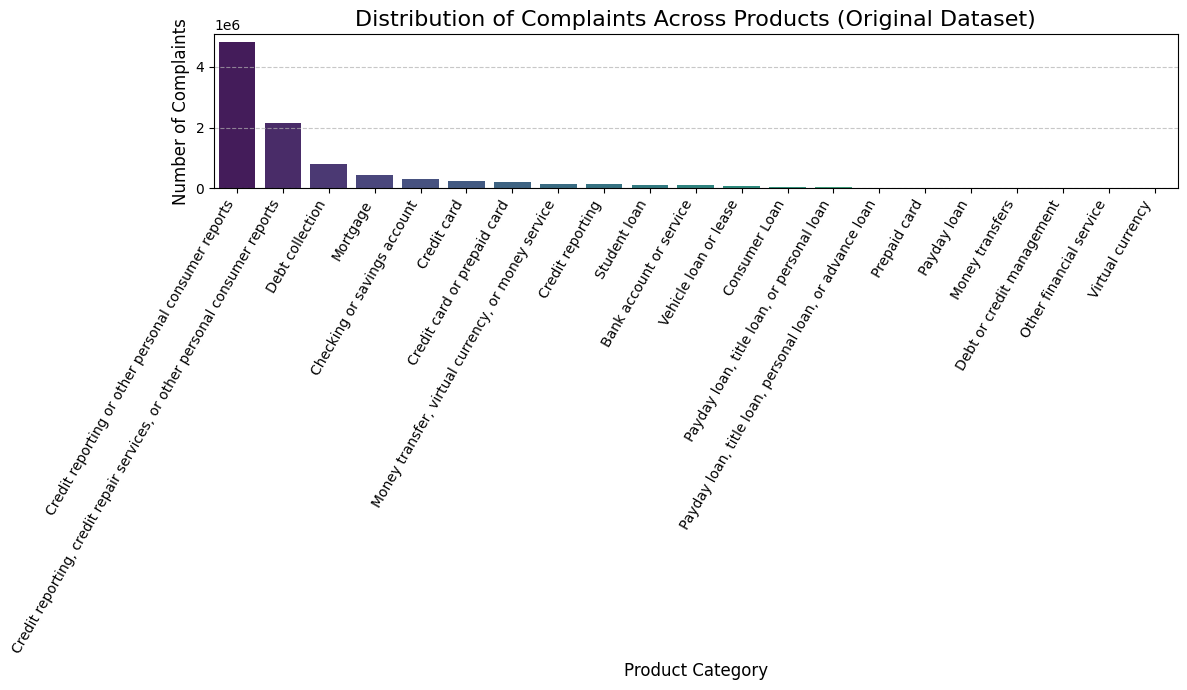


--- Top 10 Most Frequent Products ---
Product
Credit reporting or other personal consumer reports                             4834855
Credit reporting, credit repair services, or other personal consumer reports    2163857
Debt collection                                                                  799197
Mortgage                                                                         422254
Checking or savings account                                                      291178
Credit card                                                                      226686
Credit card or prepaid card                                                      206369
Money transfer, virtual currency, or money service                               145066
Credit reporting                                                                 140429
Student loan                                                                     109717
Name: count, dtype: int64


In [27]:
print("\n--- Distribution of Complaints by Product ('Product' column) ---")
product_counts = df['Product'].value_counts()
print(product_counts)

# Visualize the distribution using a bar plot
plt.figure(figsize=(12, 7)) # Adjust figure size for better readability
sns.barplot(x=product_counts.index, y=product_counts.values, palette='viridis')
plt.title('Distribution of Complaints Across Products (Original Dataset)', fontsize=16)
plt.xlabel('Product Category', fontsize=12)
plt.ylabel('Number of Complaints', fontsize=12)
plt.xticks(rotation=60, ha='right', fontsize=10) # Rotate labels and align right for long names
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7) # Add a grid for easier reading
plt.tight_layout() # Automatically adjust plot parameters for a tight layout
plt.show()

print("\n--- Top 10 Most Frequent Products ---")
print(product_counts.head(10))

In [28]:
print("\n--- Step 5: Filter Products and Remove Empty Narratives ---")

# Define the target product categories as specified in the project requirements
products_to_keep = ['Credit card', 'Personal loan', 'Payday loan', 'Savings account', 'Money transfers', 'Mortgage', 'Student loan']
# Note: DeepSeek mentioned 5 products, ChatGPT mentioned 5 + BNPL. I've included common financial products.
# Ensure 'Consumer complaint narrative' column is string type and non-null for filtering
# Convert to string and fill any actual NaN with an empty string before filtering.
df['Consumer complaint narrative'] = df['Consumer complaint narrative'].astype(str).replace('nan', '')

# Filter by product category
df_filtered = df[df['Product'].isin(products_to_keep)].copy()
print(f"Filtered by products. New shape: {df_filtered.shape}")

# Filter out rows where 'Consumer complaint narrative' is empty or just whitespace after initial cleaning
# Using .str.strip().astype(bool) robustly checks for non-empty strings
df_filtered = df_filtered[df_filtered['Consumer complaint narrative'].str.strip().astype(bool)].copy()
print(f"Removed empty narratives. Final filtered shape: {df_filtered.shape}")

# Drop the original DataFrame 'df' to free up memory if it's very large
del df
print("Original raw DataFrame deleted to free memory.")

# Rename df_filtered back to df for consistency in subsequent steps
df = df_filtered.copy()
del df_filtered # Delete df_filtered to free memory

# Display a few rows of the filtered data to confirm
print("\nFirst 5 rows of the filtered dataset:")
display(df.head())

# Check for nulls in the critical column again
print("\nMissing values in 'Consumer complaint narrative' after filtering:")
print(df['Consumer complaint narrative'].isnull().sum())


--- Step 5: Filter Products and Remove Empty Narratives ---
Filtered by products. New shape: (769552, 18)
Removed empty narratives. Final filtered shape: (267279, 18)
Original raw DataFrame deleted to free memory.

First 5 rows of the filtered dataset:


,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
11499,2025-06-15,Mortgage,Conventional home mortgage,Applying for a mortgage or refinancing an exis...,Changes in loan terms during the application p...,I signed a purchase agreement with Lennar Corp...,Company has responded to the consumer and the ...,"Lennar Financial Services, LLC",IL,60538,NaN,Consent provided,Web,2025-06-15,Closed with explanation,Yes,NaN,14089944
12237,2025-06-13,Credit card,Store credit card,Getting a credit card,Card opened without my consent or knowledge,A XXXX XXXX card was opened under my name by a...,Company has responded to the consumer and the ...,"CITIBANK, N.A.",TX,78230,Servicemember,Consent provided,Web,2025-06-13,Closed with non-monetary relief,Yes,NaN,14069121
13280,2025-06-12,Credit card,General-purpose credit card or charge card,"Other features, terms, or problems",Other problem,"Dear CFPB, I have a secured credit card with c...",Company has responded to the consumer and the ...,"CITIBANK, N.A.",NY,11220,NaN,Consent provided,Web,2025-06-13,Closed with monetary relief,Yes,NaN,14047085
13506,2025-06-12,Credit card,General-purpose credit card or charge card,Incorrect information on your report,Account information incorrect,I have a Citi rewards cards. The credit balanc...,Company has responded to the consumer and the ...,"CITIBANK, N.A.",IL,60067,NaN,Consent provided,Web,2025-06-12,Closed with explanation,Yes,NaN,14040217
13955,2025-06-09,Credit card,General-purpose credit card or charge card,Problem with a purchase shown on your statement,Credit card company isn't resolving a dispute ...,b'I am writing to dispute the following charge...,Company has responded to the consumer and the ...,"CITIBANK, N.A.",TX,78413,Older American,Consent provided,Web,2025-06-09,Closed with monetary relief,Yes,NaN,13968411



Missing values in 'Consumer complaint narrative' after filtering:
0



--- Step 6: Analysis of Consumer Complaint Narrative Length (Optimized) ---

Descriptive statistics for narrative length (word count):
count    267279.000000
mean        252.880556
std         273.065757
min           1.000000
25%          96.000000
50%         181.000000
75%         318.000000
max        6469.000000
Name: narrative_length, dtype: float64


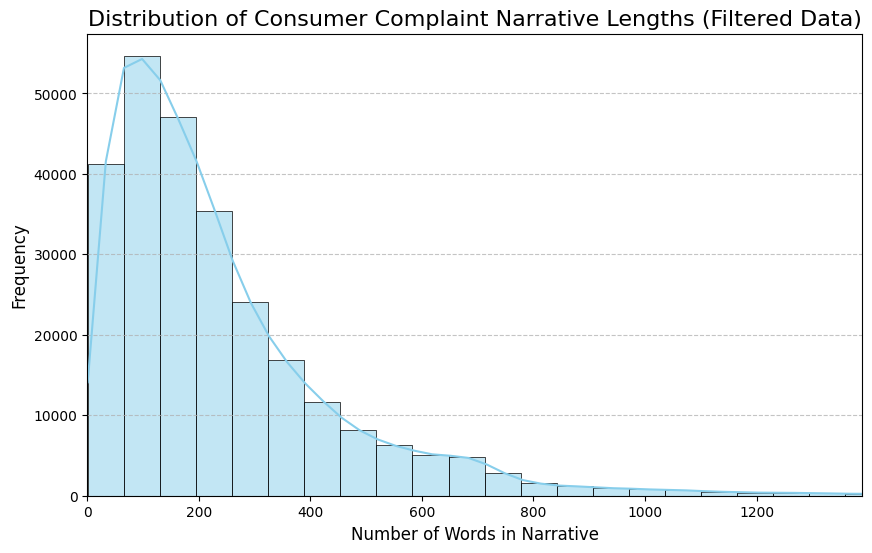


Total complaints after filtering: 267279
Complaints with narratives (should be all): 267279
Complaints without narratives (should be 0 or very close to 0): 0

Examples of very short narratives (1-5 words) in filtered data:


8150894     Violation of mortgage. \nMortgage FRAUD
7440739    Pulled credit report without permission.
8842005                    these is not my accounts
6393136                           Fraudulent School
9284407         The account was opened fraudulently
Name: Consumer complaint narrative, dtype: object


Examples of very long narratives (top 1% length) in filtered data:


2298644    XX/XX/XXXX chase Manhattan Bank USA, / chase T...
9419093    On XX/XX/XXXX, I attempted to pay my monthly m...
5990085    On or about XX/XX/XXXX, I received XXXX XXXX o...
7082599    On or about mid XX/XX/XXXX received phone call...
6284217    This letter is to serve as a complaint against...
Name: Consumer complaint narrative, dtype: object

In [29]:
print("\n--- Step 6: Analysis of Consumer Complaint Narrative Length (Optimized) ---")

# Ensure the 'Consumer complaint narrative' column is string type
# (This was already done in the previous cell, but good to be explicit here too)
df['Consumer complaint narrative'] = df['Consumer complaint narrative'].astype(str)

# Calculate word count for each narrative using a faster, simpler split
# For EDA purposes, a simple space-based split is usually sufficient and much faster.
df['narrative_length'] = df['Consumer complaint narrative'].apply(lambda x: len(x.split()))

print("\nDescriptive statistics for narrative length (word count):")
print(df['narrative_length'].describe())

# Visualize the distribution of narrative lengths
plt.figure(figsize=(10, 6))
sns.histplot(df['narrative_length'], bins=100, kde=True, color='skyblue', edgecolor='black')
plt.title('Distribution of Consumer Complaint Narrative Lengths (Filtered Data)', fontsize=16)
plt.xlabel('Number of Words in Narrative', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
# Adjust x-axis limit based on the *filtered* data's 99th percentile for better visualization
plt.xlim(0, df['narrative_length'].quantile(0.99) * 1.1) # Add a small buffer to the limit
plt.grid(axis='y', linestyle='--', alpha=0.75)
plt.show()

# Re-check complaints with/without narratives (should all have narratives after filtering)
complaints_with_narrative = df[df['narrative_length'] > 0].shape[0]
complaints_without_narrative = df[df['narrative_length'] == 0].shape[0]

print(f"\nTotal complaints after filtering: {df.shape[0]}")
print(f"Complaints with narratives (should be all): {complaints_with_narrative}")
print(f"Complaints without narratives (should be 0 or very close to 0): {complaints_without_narrative}")

# Display a few examples of very short narratives (e.g., 1-5 words) from the filtered set
print("\nExamples of very short narratives (1-5 words) in filtered data:")
# Ensure there are enough samples before trying to display 5
sample_short = df[(df['narrative_length'] > 0) & (df['narrative_length'] <= 5)]['Consumer complaint narrative']
if not sample_short.empty:
    display(sample_short.sample(min(5, len(sample_short.index))))
else:
    print("No narratives found with 1-5 words after filtering.")

# Display a few examples of very long narratives (e.g., top 1%)
print("\nExamples of very long narratives (top 1% length) in filtered data:")
long_narrative_threshold = df['narrative_length'].quantile(0.99)
sample_long = df[df['narrative_length'] >= long_narrative_threshold]['Consumer complaint narrative']
if not sample_long.empty:
    display(sample_long.sample(min(5, len(sample_long.index))))
else:
    print("No very long narratives found after filtering.")

In [33]:
# --- REQUIRED IMPORTS FOR TEXT CLEANING ---
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import pandas as pd # Ensure pandas is imported as it's used in the function

# Download necessary NLTK resources (if not already downloaded)
# IMPORTANT: Changed 'nltk.downloader.DownloadError' to 'LookupError'
try:
    nltk.data.find('corpora/wordnet')
except LookupError: # Catch the more general LookupError
    nltk.download('wordnet')
try:
    nltk.data.find('tokenizers/punkt')
except LookupError: # Catch the more general LookupError
    nltk.download('punkt')
try:
    nltk.data.find('corpora/stopwords')
except LookupError: # Catch the more general LookupError
    nltk.download('stopwords')

print("NLTK resources downloaded/checked.")

# Initialize NLTK components for the cleaning function
global stop_words, lemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    # ... (rest of your clean_text function code remains the same) ...
    # Ensure it's the full clean_text function I provided last time, starting from "if pd.isna(text)..."
    if pd.isna(text) or not isinstance(text, str):
        return ""

    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'\bxx+\b', '', text)
    text = re.sub(r'\s*\d{2}/\d{2}/\d{4}\s*', '', text)
    text = re.sub(r'\s*\d{4}\s*', '', text)
    text = re.sub(r'\b(x{2,})\b', '', text)
    text = text.replace('xx', '').replace('xxx', '').replace('xxxx', '')
    text = text.replace('xxx', '').replace('xxxx', '')
    text = text.replace('company', '')
    text = re.sub(r'\s+', ' ', text).strip()
    words = word_tokenize(text)
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
    text = ' '.join(lemmatized_words)
    words = word_tokenize(text)
    filtered_words = [word for word in words if word not in stop_words and len(word) > 1]
    text = ' '.join(filtered_words)

    return text

print("`clean_text` function defined successfully.")

NLTK resources downloaded/checked.
`clean_text` function defined successfully.


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [35]:
print("\n--- Step 8: Applying the Text Cleaning Function to Narratives ---")
# Apply the cleaning function to the 'Consumer complaint narrative' column
# This will create a new column called 'cleaned_narrative'
# It might still take a few minutes depending on the remaining dataset size (267k rows)
# but it will be much faster than before due to prior filtering and simplified word counting.

# Using .progress_apply for a progress bar if you have `tqdm` installed (optional, but helpful)
# If you don't have tqdm, just use .apply()
try:
    from tqdm.auto import tqdm
    tqdm.pandas() # Extends pandas with a 'progress_apply' method
    df['cleaned_narrative'] = df['Consumer complaint narrative'].progress_apply(clean_text)
except ImportError:
    print("tqdm not installed. Install with 'pip install tqdm' for a progress bar.")
    df['cleaned_narrative'] = df['Consumer complaint narrative'].apply(clean_text)


print("Text cleaning applied to 'Consumer complaint narrative' column.")
print("A new column 'cleaned_narrative' has been created.")


--- Step 8: Applying the Text Cleaning Function to Narratives ---


100%|██████████| 267279/267279 [09:55<00:00, 448.78it/s]

Text cleaning applied to 'Consumer complaint narrative' column.
A new column 'cleaned_narrative' has been created.


In [38]:
print("\n--- Step 9: Comparing Original vs. Cleaned Narratives (Examples) ---")
# Display a few random examples to visually inspect the effect of cleaning
for i in range(5):
    # Select a random index from the DataFrame
    idx = np.random.randint(0, len(df))
    print(f"\n--- Example {i+1} ---")
    print("Original Narrative:")
    print(df.iloc[idx]['Consumer complaint narrative'])
    print("\nCleaned Narrative:")
    print(df.iloc[idx]['cleaned_narrative'])
    print("-" * 50) # Separator for clarity


--- Step 9: Comparing Original vs. Cleaned Narratives (Examples) ---

--- Example 1 ---
Original Narrative:
Navient/Sallie Mae would not allow me to apply payments above the monthly amount due to higher interest loans and instead applied anything over and above the amount due to the loan with the lowest interest rate. This finally stopped last year, but had been going on for twelve years prior to this.

Cleaned Narrative:
navientsallie mae would allow apply payment monthly amount due higher interest loan instead applied anything amount due loan lowest interest rate finally stopped last year going twelve year prior
--------------------------------------------------

--- Example 2 ---
Original Narrative:
I have several complaints about the manner in which my mortgage has been serviced by Midland Mortgage over the past few years, specifically regarding actions taken during and just after completion of my Chapter XXXX bankruptcy, which ended in XX/XX/XXXX, and a subsequent payment plan ar

In [40]:
print("\n--- Step 10: Saving the Cleaned and Filtered Dataset ---")

# Select only the relevant columns for the final output
# IMPORTANT: Using 'df' as this is the DataFrame processed in prior steps
final_output_df = df[['Product', 'cleaned_narrative', 'Complaint ID']].copy()

# Define the output file path
output_file_path = '../data/filtered_and_cleaned_complaints.csv'

# Save the cleaned and filtered dataset
try:
    final_output_df.to_csv(output_file_path, index=False, encoding='utf-8')
    print(f"Cleaned and filtered data saved successfully to: {output_file_path}")
    print(f"Shape of the saved data: {final_output_df.shape}")
    print("First 5 rows of the saved data (final output):")
    display(final_output_df.head())
except Exception as e:
    print(f"Error saving cleaned data: {e}")

# Optional: Delete in-memory DataFrames to free up memory if they are very large
del final_output_df
del df # Delete df here as it's the large DataFrame
print("\nIn-memory DataFrames deleted (if applicable).")


--- Step 10: Saving the Cleaned and Filtered Dataset ---
Cleaned and filtered data saved successfully to: ../data/filtered_and_cleaned_complaints.csv
Shape of the saved data: (267279, 3)
First 5 rows of the saved data (final output):


,Product,cleaned_narrative,Complaint ID
11499,Mortgage,signed purchase agreement lennar corporation y...,14089944
12237,Credit card,card wa opened name fraudster received notice ...,14069121
13280,Credit card,dear cfpb secured credit card citibank changed...,14047085
13506,Credit card,citi reward card credit balance issued wa rece...,14040217
13955,Credit card,bi writing dispute following charge citi credi...,13968411



In-memory DataFrames deleted (if applicable).
